In [28]:
#!pip install scikit-optimize

In [43]:
import pandas as pd
import numpy as np
# import os
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import plotly.graph_objs as go

import missingno as msno
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler as stdscale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import skopt

In [ ]:
#Seaborn settings for visualizations!
# rc = {
#     "axes.facecolor": "#f7f9fc",
#     "figure.facecolor": "#f7f9fc",
#     "axes.edgecolor": "#000000",
#     "grid.color": "#EBEBE7",
#     "font.family": "serif",
#     "axes.labelcolor": "#000000",
#     "xtick.color": "#000000",
#     "ytick.color": "#000000",
#     "grid.alpha": 0.4
# }

# default_palette = 'YlOrRd'

# sns.set(rc=rc)
# pd.set_option('display.max_columns',35)
# pd.options.display.float_format = '{:,.2f}'.format

In [31]:
file_name = './../../../dataset/2021_stat.csv'
table = pd.read_csv(file_name, quoting=csv.QUOTE_NONE, on_bad_lines='skip').dropna()

for col in table.columns:
  table.columns = table.columns.str.replace('"', '')

model_data = table[[ 'ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B','FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'NUM_UNIT', 'OCC_Principal', 'OCC_Second', 'OCC_Investor', 'MI_PCT', 'DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured']]
for col in model_data.select_dtypes(include=['object']).columns:
    model_data[col] = model_data[col].str.replace('"', '', regex=False)
    model_data[col] = pd.to_numeric(model_data[col], errors='coerce')
model_data = model_data.dropna()
model_data

/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_33178/3752069596.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[col] = model_data[col].str.replace('"', '', regex=False)
/var/folders/js/zv14t_p906xd0p0p9fq7clrw0000gn/T/ipykernel_33178/3752069596.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[col] = pd.to_numeric(model_data[col], errors='coerce')


,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,NUM_UNIT,OCC_Principal,OCC_Second,OCC_Investor,MI_PCT,DLQ_30_FLAG,DLQ_90_FLAG,Ongoing,Current_DLQ,Prepaid_Matured
0,2.12,"619,000.00",180,69.00,1,48.00,798.00,0,0,1,0,1,1,0,0,0.00,0,0,1,0,0
1,2.62,"636,000.00",360,80.00,2,33.00,792.00,1,0,0,1,1,1,0,0,0.00,0,0,1,0,0
2,2.62,"589,000.00",180,60.00,2,22.00,773.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
3,2.75,"715,000.00",360,92.00,1,35.00,801.00,1,0,0,1,1,1,0,0,30.00,0,0,1,0,0
4,2.62,"750,000.00",360,29.00,2,30.00,793.00,0,0,1,0,1,1,0,0,0.00,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782087,2.50,"160,000.00",360,62.00,1,17.00,803.00,0,0,1,0,1,1,0,0,0.00,0,0,0,0,1
4782088,2.99,"450,000.00",360,90.00,1,36.00,740.00,1,0,0,1,1,1,0,0,25.00,0,0,1,0,0
4782089,2.50,"153,000.00",180,70.00,2,31.00,770.00,0,1,0,0,1,1,0,0,0.00,0,0,1,0,0
4782090,2.50,"250,000.00",180,51.00,2,40.00,755.00,0,1,0,0,1,1,0,0,0.00,0,0,1,0,0


In [32]:
# Definition of Bad Loans: once had a 90-day delinquency in performance history
# Definition of Good Loans: no delinquency and continuous payments up to current
model_data = model_data[ (model_data['DLQ_90_FLAG'] == 1) | ( (model_data['DLQ_90_FLAG'] == 0) & (model_data['Ongoing'] == 1) ) ]
model_data = model_data.astype(float)
X = model_data.drop(columns=['DLQ_30_FLAG', 'DLQ_90_FLAG', 'Ongoing', 'Current_DLQ', 'Prepaid_Matured'])
y = model_data['DLQ_90_FLAG']


In [33]:
num_col = ['ORIG_RATE', 'ORIG_AMOUNT', 'ORIG_TERM', 'OLTV', 'NUM_BO', 'DTI', 'CSCORE_B', # 'CSCORE_C',
           'NUM_UNIT', 'MI_PCT']
cat_col = ['FTHB_FLAG', 'PUR_Cash_out', 'PUR_Refinance', 'PUR_Purchase', 'OCC_Principal', 'OCC_Second', 'OCC_Investor']
scaler = stdscale()
X[num_col] = scaler.fit_transform(X[num_col])
X = pd.concat([X[num_col], X[cat_col]], axis=1)

X

,ORIG_RATE,ORIG_AMOUNT,ORIG_TERM,OLTV,NUM_BO,DTI,CSCORE_B,NUM_UNIT,MI_PCT,FTHB_FLAG,PUR_Cash_out,PUR_Refinance,PUR_Purchase,OCC_Principal,OCC_Second,OCC_Investor
0,-1.86,2.30,-1.68,0.08,-0.91,1.45,0.84,-0.11,-0.47,0.00,0.00,1.00,0.00,1.00,0.00,0.00
1,-0.68,2.41,0.61,0.66,1.02,-0.06,0.70,-0.11,-0.47,1.00,0.00,0.00,1.00,1.00,0.00,0.00
3,-0.37,2.95,0.61,1.31,-0.91,0.14,0.91,-0.11,2.37,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,-0.68,3.19,0.61,-2.06,1.02,-0.36,0.72,-0.11,-0.47,0.00,0.00,1.00,0.00,1.00,0.00,0.00
5,-0.96,2.20,0.61,-0.35,-0.91,-0.16,0.19,-0.11,-0.47,0.00,0.00,1.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4782086,2.29,-0.67,0.61,0.40,1.02,-0.56,-0.36,-0.11,-0.47,0.00,1.00,0.00,0.00,0.00,0.00,1.00
4782088,0.19,1.14,0.61,1.20,-0.91,0.24,-0.50,-0.11,1.90,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4782089,-0.96,-0.89,-1.68,0.13,1.02,-0.26,0.19,-0.11,-0.47,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4782090,-0.96,-0.23,-1.68,-0.88,1.02,0.64,-0.15,-0.11,-0.47,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)


### Univariate Analysis

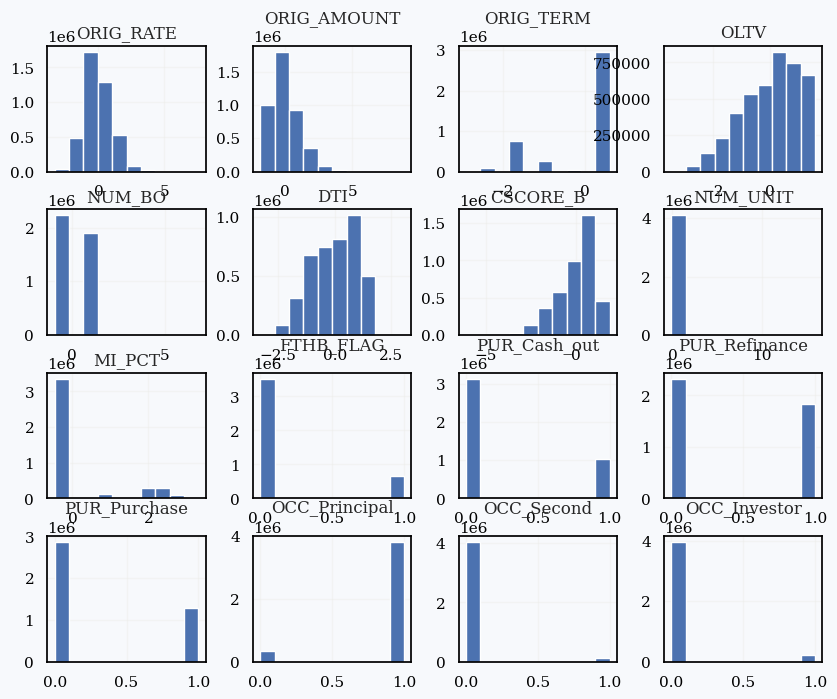

In [35]:
X.hist(figsize=(10,8));

### Bivariate Analysis and heat Map

In [36]:
model_data.corr(method='pearson', numeric_only=True)
fig = go.Figure(go.Heatmap(z=model_data.corr(method='pearson', numeric_only=True), x=model_data.corr(method='pearson', numeric_only=True).columns.tolist(), y=model_data.corr(method='pearson', numeric_only=True).corr().columns.tolist(), colorscale='agsunset'))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### Missing Values

<Axes: >

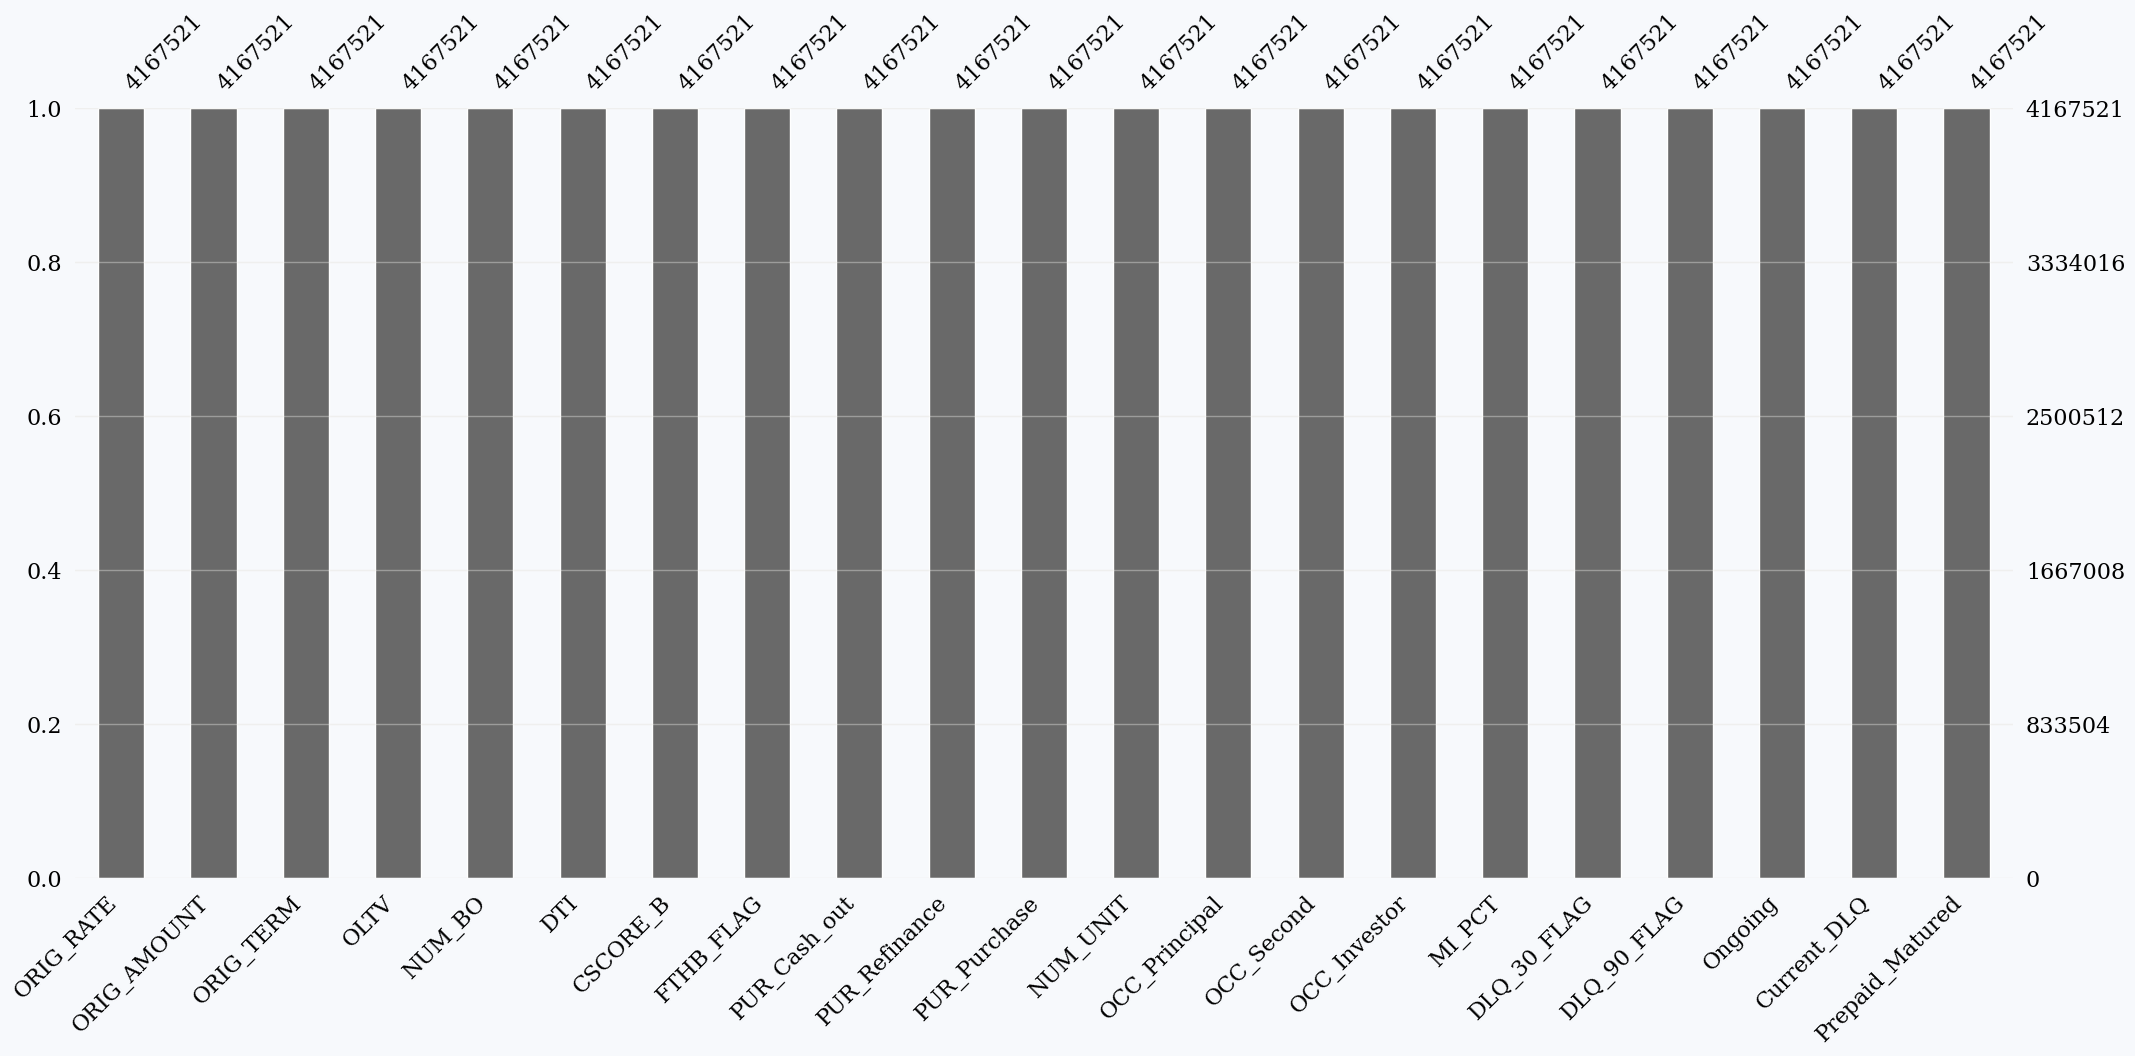

In [37]:
msno.bar(model_data)

In [38]:
model = XGBClassifier(enable_categorical=True, eval_metric='auc')
smote = SMOTE()

pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('model', model)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='auc',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [39]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9582069926423128
AUC-ROC: 0.5542944676823103
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98   1233371
         1.0       0.06      0.14      0.08     16886

    accuracy                           0.96   1250257
   macro avg       0.52      0.55      0.53   1250257
weighted avg       0.98      0.96      0.97   1250257



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

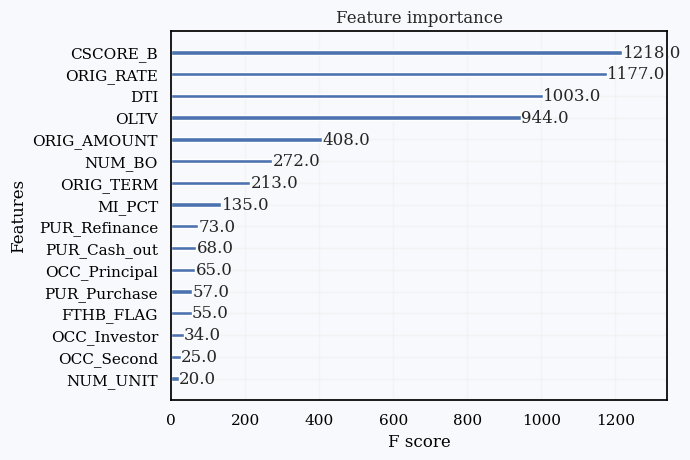

In [40]:
xgb.plot_importance(pipeline['model'])


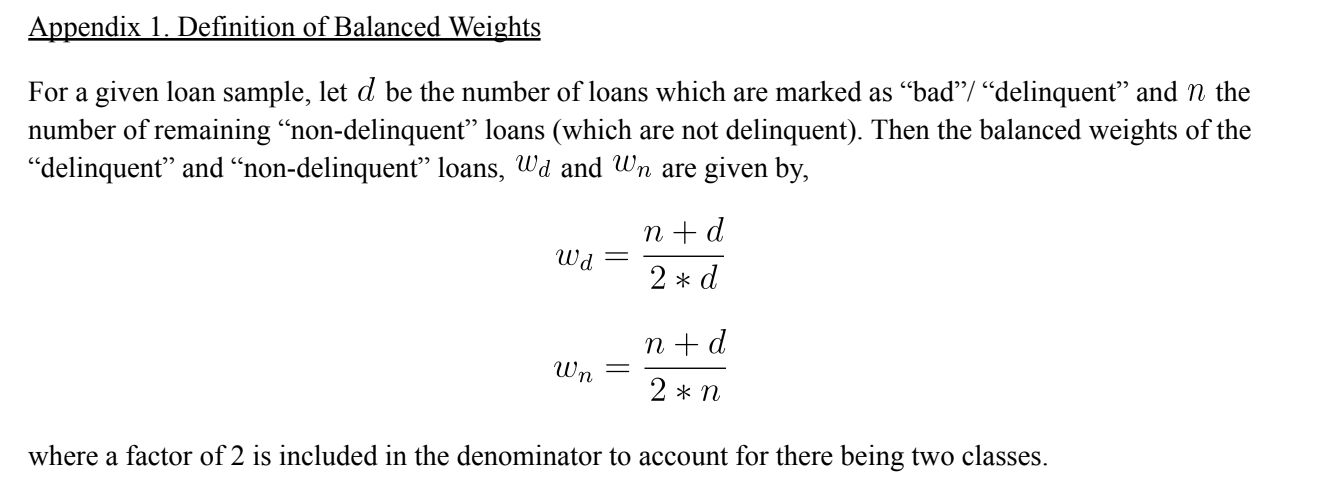

In [41]:
weight_deliquent = len(X_train)/(2*sum(y_train))
scalar_weight_xgb = XGBClassifier(scale_pos_weight=weight_deliquent, eval_metric='auc')
scalar_weight_xgb.fit(X_train, y_train)

y_pred = scalar_weight_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8490574337916125
AUC-ROC: 0.7181263412710664
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92   1233371
         1.0       0.05      0.58      0.09     16886

    accuracy                           0.85   1250257
   macro avg       0.52      0.72      0.51   1250257
weighted avg       0.98      0.85      0.91   1250257



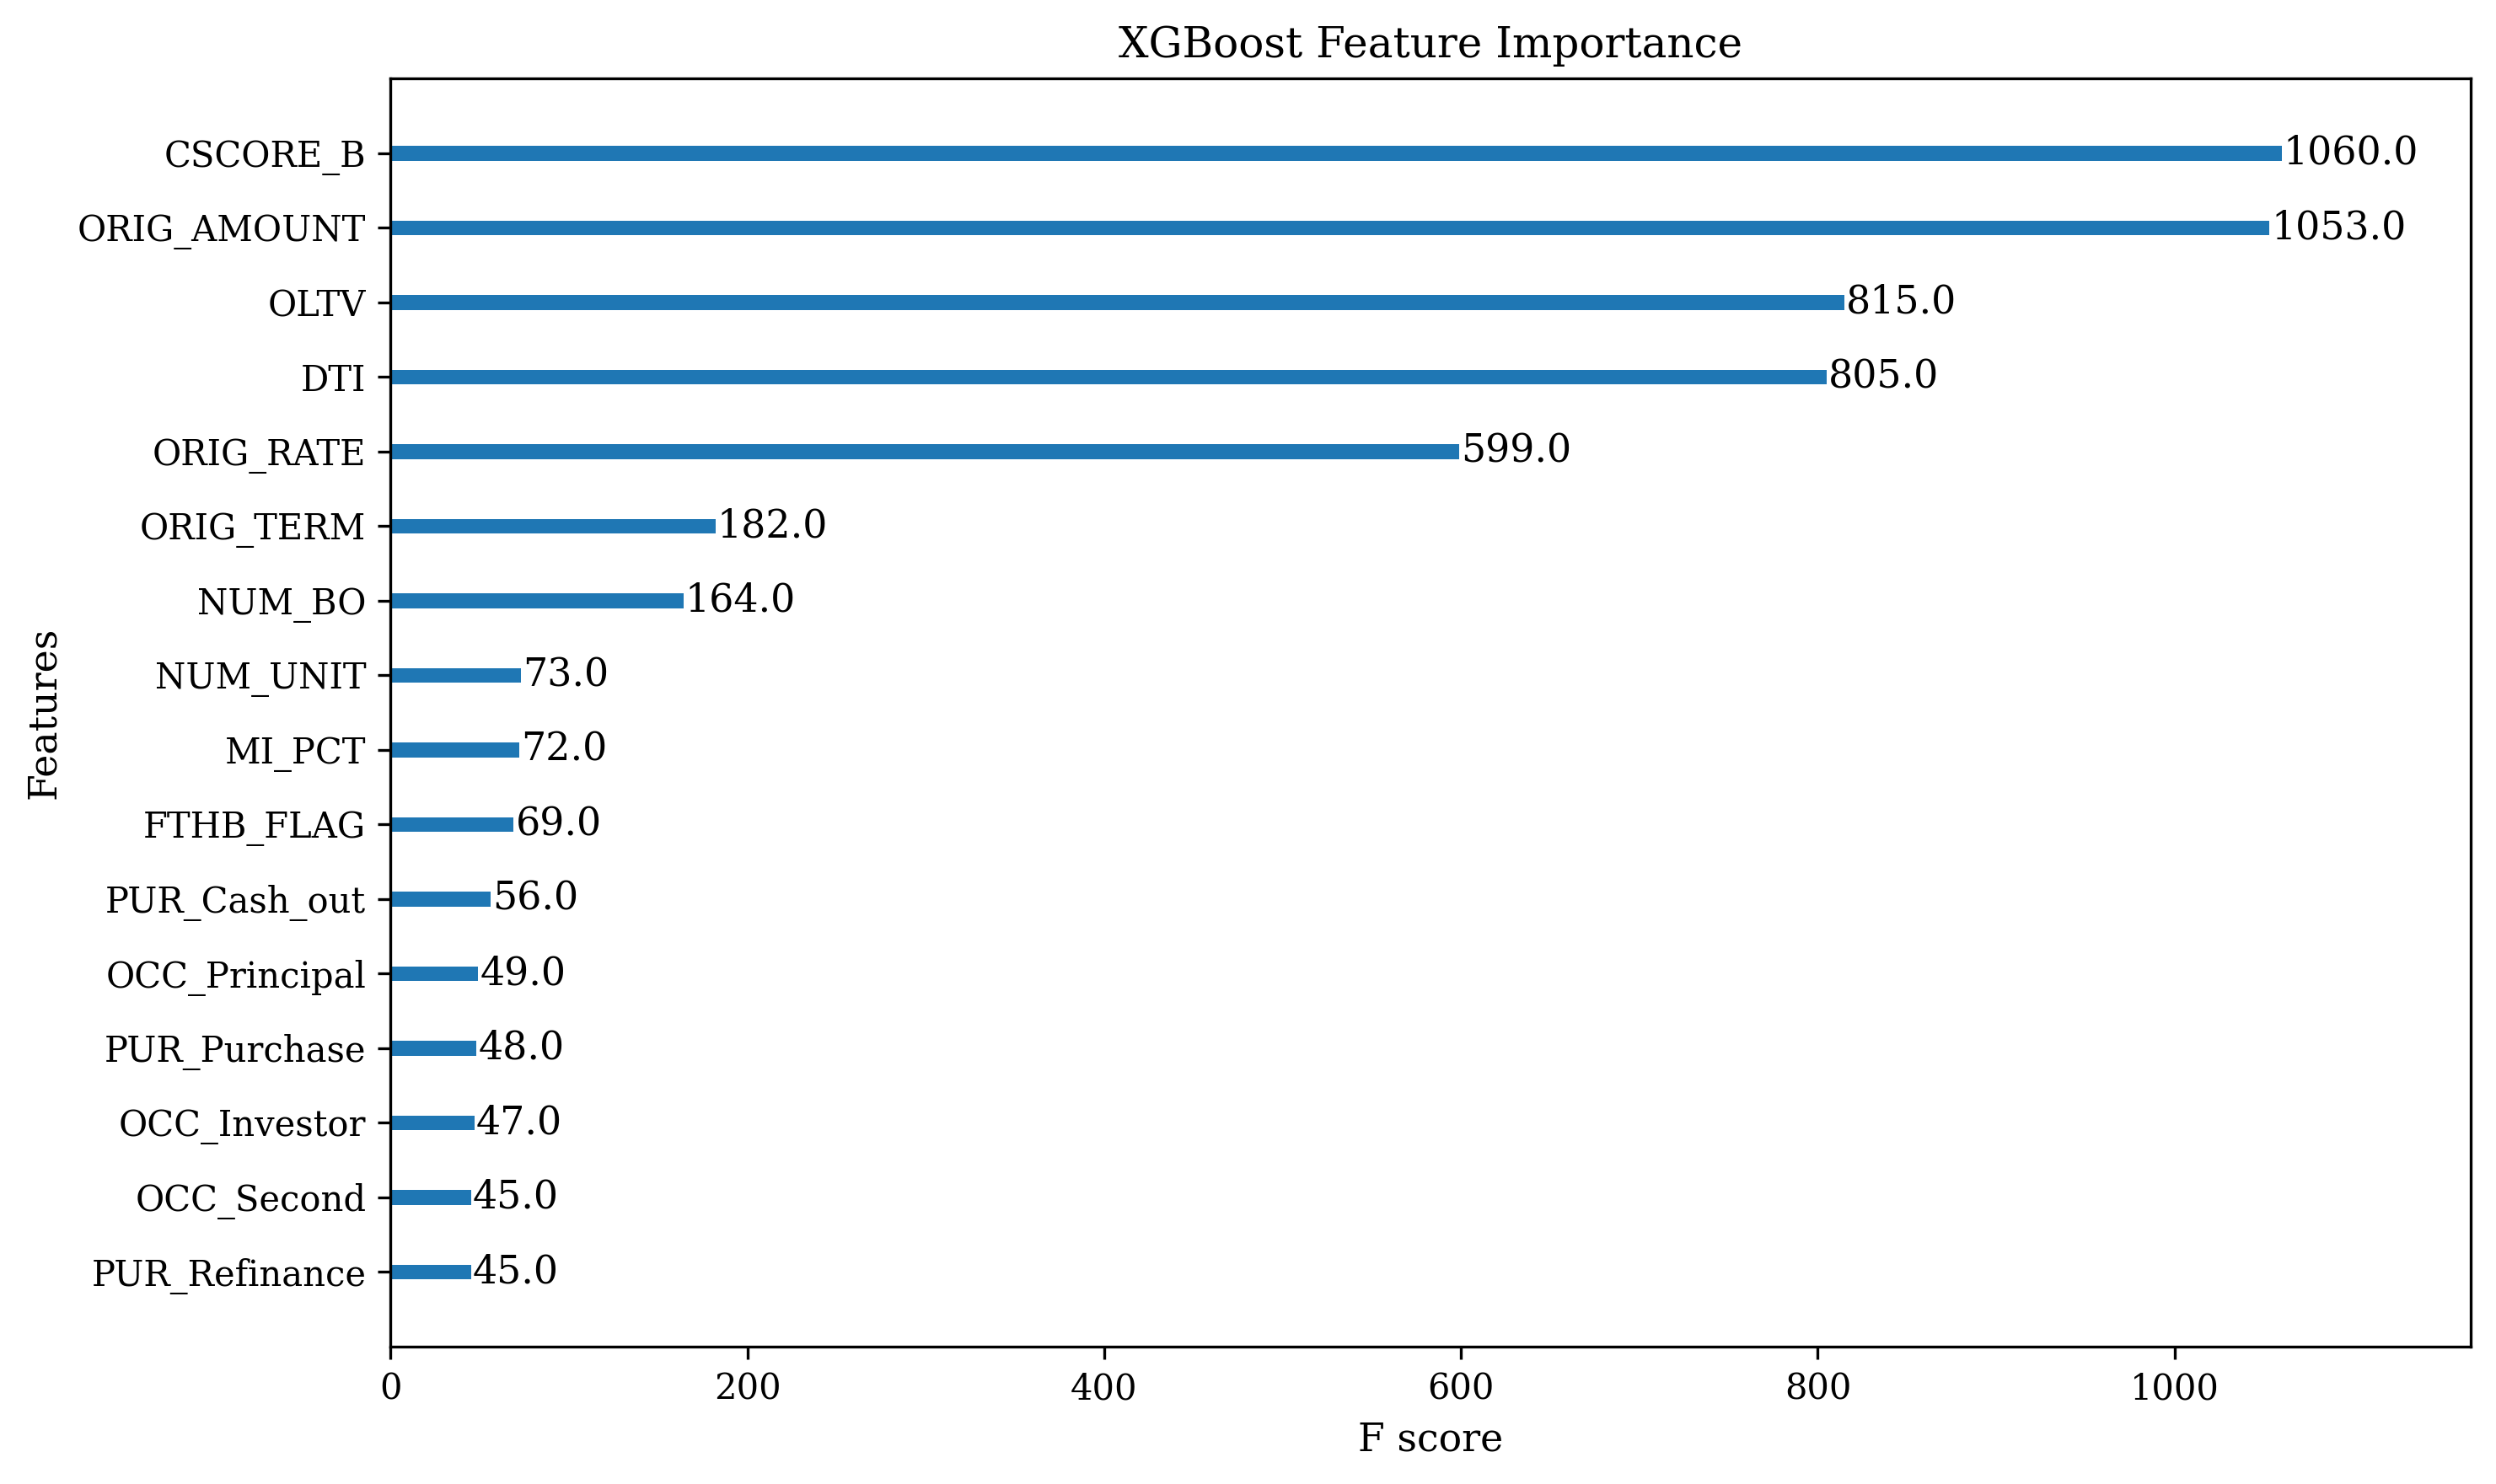

In [54]:

mpl.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.size': 11,  # General font size
    'axes.titlesize': 12,  # Title font size
    'axes.labelsize': 11,  # Label font size
    'xtick.labelsize': 10,  # X-axis tick font size
    'ytick.labelsize': 10,  # Y-axis tick font size
    'legend.fontsize': 10,  # Legend font size
    'figure.dpi': 300,  # Higher resolution for reports
    'savefig.dpi': 300,  # Resolution for saved figures
})
ax = xgb.plot_importance(scalar_weight_xgb)
ax.grid(False)
fig = ax.get_figure()
fig.set_size_inches(10, 6)  
ax.set_title("XGBoost Feature Importance")

plt.tight_layout()
plt.show()


In [ ]:
search_space = {
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.03, "log-uniform"),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.1, 1),
    # "gamma": (1e-8, 1.0, "log-uniform"),
    # "min_child_weight": (1, 10),
}

opt = skopt.BayesSearchCV(
    estimator=XGBClassifier(eval_metric='auc', random=99, scale_pos_weight=weight_deliquent),
    search_spaces=search_space,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=3
)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[16:21:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "random" } are not used.




BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='auc', feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=Non...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random=99, ...),
              n_iter=20, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.1, 1),
                             'learning_rate': (0.01, 0.03, 'log-uniform'),
                             'max_depth': (3, 10), 'subsample': (0.5, 1.0)},
              verbose=3)

In [ ]:
print("Best parameters:", opt.best_params_)
print("Best cross-validation score:", opt.best_score_)

Best parameters: OrderedDict([('colsample_bytree', 0.9208625186943955), ('learning_rate', 0.029999999999999995), ('max_depth', 8), ('subsample', 1.0)])
Best cross-validation score: 0.8442729496912857


In [ ]:

optimal_xgb = XGBClassifier(
    scale_pos_weight=weight_deliquent,
    colsample_bytree=0.9208625186943955,
    learning_rate=0.03,
    max_depth=8,
    subsample=1.0,
    eval_metric='auc')
optimal_xgb.fit(X_train, y_train)

y_pred = optimal_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC-ROC: {roc_auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8685732923801772
AUC-ROC: 0.739075008552829
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    950161
         1.0       0.12      0.60      0.21     27867

    accuracy                           0.87    978028
   macro avg       0.56      0.74      0.57    978028
weighted avg       0.96      0.87      0.91    978028



In [48]:
mpl.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.size': 11,  # General font size
    'axes.titlesize': 12,  # Title font size
    'axes.labelsize': 11,  # Label font size
    'xtick.labelsize': 10,  # X-axis tick font size
    'ytick.labelsize': 10,  # Y-axis tick font size
    'legend.fontsize': 10,  # Legend font size
    'figure.dpi': 300,  # Higher resolution for reports
    'savefig.dpi': 300,  # Resolution for saved figures
})
xgb.plot_importance(optimal_xgb)


NameError: name 'optimal_xgb' is not defined

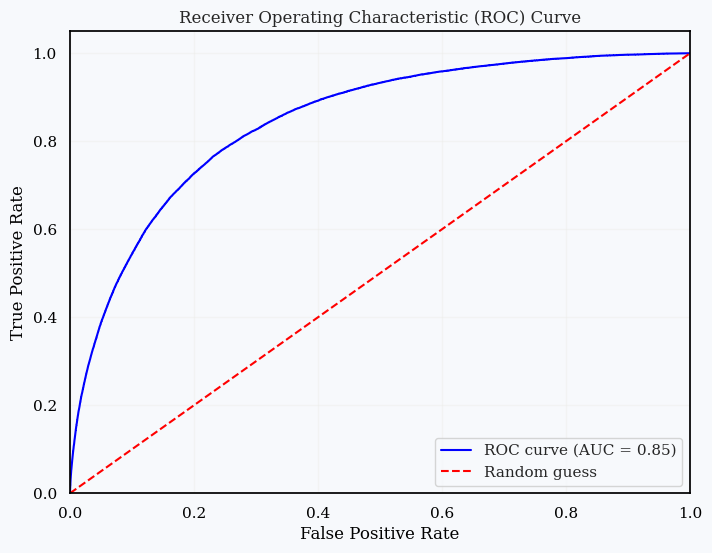

In [ ]:
y_pred_proba = optimal_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()